In [41]:
# Data Visualization
import matplotlib.pyplot as plt

# Data Manipulation
import numpy as np
import pandas as pd

# Word2Vec Loading
import gensim.downloader as api
from gensim.models import KeyedVectors

# Trie for fast lookup
from datrie import BaseTrie
import string

# Dimensionality Reduction
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import rand_score, adjusted_rand_score

import os

import seaborn as sns

In [2]:
# Import Google News 300 Word2Vec dataset
w2v_model: KeyedVectors = api.load('word2vec-google-news-300')

In [3]:
# Make a Trie for O(1) lookup of containment of words
t = BaseTrie(string.ascii_lowercase)

for x in w2v_model.index_to_key:
    t[x] = True

In [4]:
# Define a helper function to get the vector of a given word
def vec(str):
    return w2v_model.vectors[w2v_model.key_to_index[str]]

In [5]:
LEN_DATA = 50

list_dirnames = []
list_data = []
for subdir, dirs, files in os.walk('./BATS_3.0'):
    for file in files:
        if file.endswith('.txt'):
            list_dirnames.append(file)
            list_data.append(pd.read_csv(os.path.join(subdir, file), sep='\t', header=None))

# Add pair_id, which uniquely identifies each pair, and relation_id, which identifies the dataset
full_df = pd.concat([ df.assign(pair_id=range(LEN_DATA*i, LEN_DATA*(i+1)), relation_id=i) for i, df in enumerate(list_data) ])

# Remove all but the first result for the second element of each pair
full_df[1] = full_df[1].str.split('/', expand=True)[0]

# Remove all pairs where one of the words are not in the word2vec dataset
full_df = full_df[full_df[0].apply(t.__contains__) & full_df[1].apply(t.__contains__)]

In [6]:
word_pair_vecs = np.vstack(full_df[0].apply(vec)) - np.vstack(full_df[1].apply(vec))

In [49]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduce', PCA(n_components=100, random_state=42))
])

In [50]:
names = pd.Series(list_dirnames).str.extract(r'\[(.*)\]')[0]
name_to_id = pd.Series(names.index.values, index=names)
relation_ids = name_to_id[['country - capital', 'male - female', 'meronyms - member']]
filter_cond = full_df['relation_id'].isin(relation_ids)

transform_filter = pipe.fit_transform(word_pair_vecs[filter_cond])

In [51]:
transform = pipe.fit_transform(word_pair_vecs)

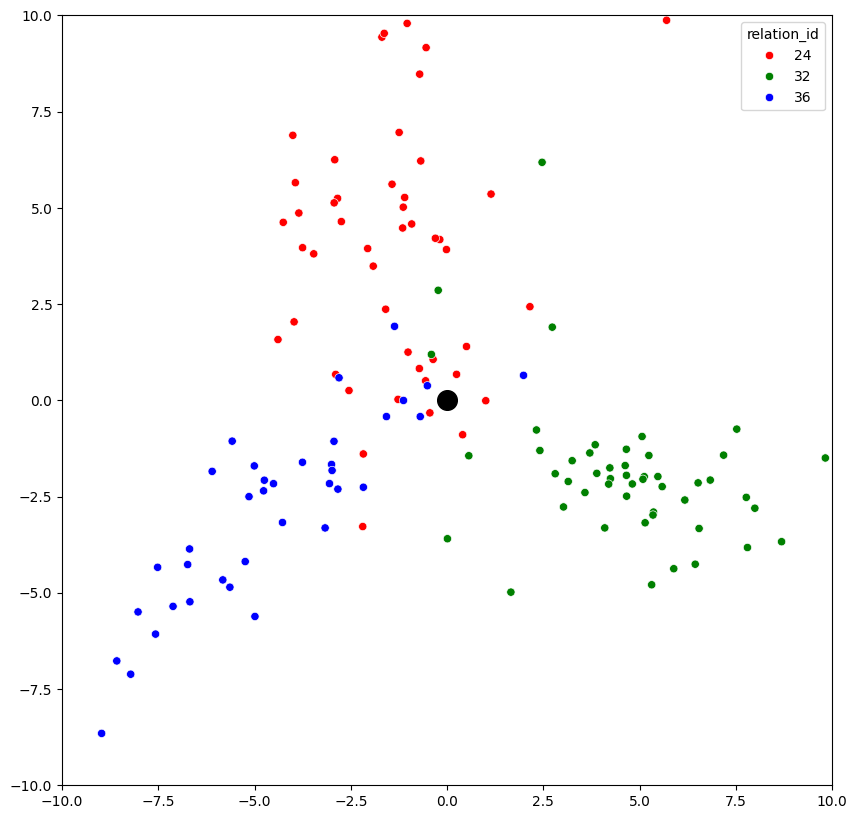

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim((-10, 10))
plt.ylim((-10, 10))
ax.set_aspect('equal')

sns.scatterplot(x=transform_filter[:, 0], y=transform_filter[:, 1], hue=full_df[filter_cond]['relation_id'], palette=['r', 'g', 'b'])
plt.scatter(0, 0, c='k', s=200);

In [53]:
clusters = KMeans(n_clusters=3).fit(transform_filter[:, :2])

In [54]:
relationship_conds = [ (id, full_df[filter_cond]['relation_id'] == id) for id in relation_ids ]
for id, cond in relationship_conds:
    print(id, names[id])
    print(pd.Series(clusters.labels_[cond]).value_counts())

36 country - capital
1    34
0     2
2     1
Name: count, dtype: int64
32 male - female
2    45
0     3
1     1
Name: count, dtype: int64
24 meronyms - member
0    40
1     7
2     2
Name: count, dtype: int64


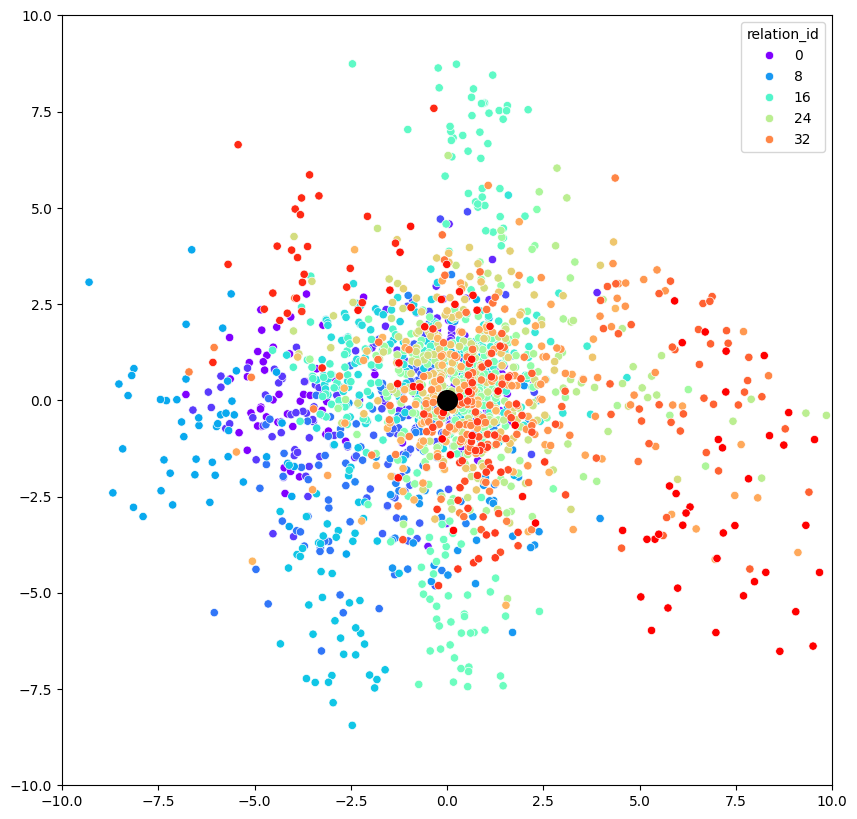

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim((-10, 10))
plt.ylim((-10, 10))
ax.set_aspect('equal')

sns.scatterplot(x=transform[:, 0], y=transform[:, 1], hue=full_df['relation_id'], palette=plt.cm.rainbow)
plt.scatter(0, 0, c='k', s=200);

In [72]:
clusters = KMeans(n_clusters=40, random_state=42).fit(transform)

In [73]:
relationship_conds = [ (id, full_df['relation_id'] == id) for id in range(40) ]
best_clusters = []
for id, cond in relationship_conds:
    print(id, names[id])
    print(pd.Series(clusters.labels_[cond]).value_counts().index[0], pd.Series(clusters.labels_[cond]).value_counts().reset_index(drop=True)[0])
    best_clusters.append(pd.Series(clusters.labels_[cond]).value_counts().index[0])

0 verb+ment_irreg
8 36
1 adj+ly_reg
9 48
2 re+verb_reg
32 41
3 verb+tion_irreg
8 38
4 un+adj_reg
37 35
5 adj+ness_reg
34 44
6 verb+able_reg
36 45
7 over+adj_reg
37 39
8 noun+less_reg
17 36
9 verb+er_irreg
12 45
10 verb_Ving - Ved
5 47
11 verb_inf - 3pSg
29 50
12 adj - superlative
10 48
13 verb_inf - Ved
27 46
14 noun - plural_irreg
0 41
15 noun - plural_reg
0 49
16 verb_inf - Ving
27 50
17 verb_3pSg - Ved
39 50
18 verb_Ving - 3pSg
25 49
19 adj - comparative
20 50
20 antonyms - binary
32 28
21 antonyms - gradable
37 19
22 synonyms - exact
32 20
23 meronyms - part
6 18
24 meronyms - member
13 17
25 synonyms - intensity
32 17
26 hypernyms - animals
13 25
27 hypernyms - misc
13 22
28 meronyms - substance
1 17
29 hyponyms - misc
32 17
30 animal - young
38 18
31 things - color
14 37
32 male - female
7 39
33 country - language
1 10
34 animal - shelter
30 13
35 name - nationality
21 10
36 country - capital
21 28
37 name - occupation
4 23
38 UK_city - county
1 8
39 animal - sound
28 39


In [74]:
best_clusters

[8,
 9,
 32,
 8,
 37,
 34,
 36,
 37,
 17,
 12,
 5,
 29,
 10,
 27,
 0,
 0,
 27,
 39,
 25,
 20,
 32,
 37,
 32,
 6,
 13,
 32,
 13,
 13,
 1,
 32,
 38,
 14,
 7,
 1,
 30,
 21,
 21,
 4,
 1,
 28]

In [77]:
adjusted_rand_score(full_df['relation_id'], clusters.labels_)

0.39517390424033527

: 

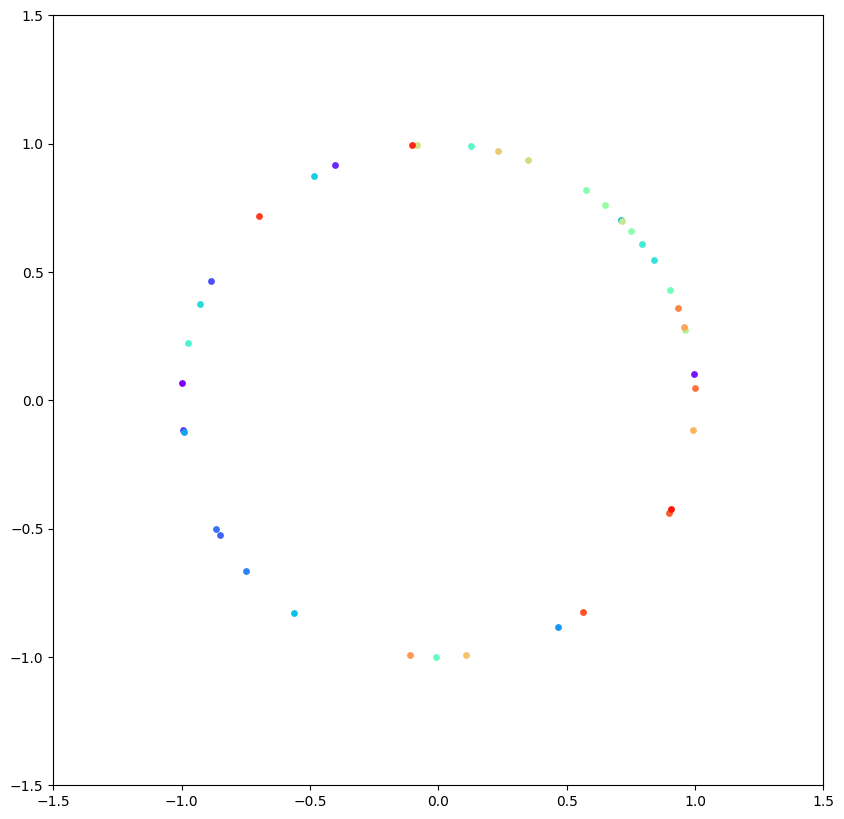

In [13]:
relations = full_df['relation_id'].unique()

fig, ax = plt.subplots(figsize=(10, 10))

# Norm each of the points; this is done because angle matters more than magnitude in Word2Vec
normed_points = transform/np.linalg.norm(transform, axis=1).reshape(-1, 1)

angles = []

for r in relations:
    # Take the average of all the angles
    mean = normed_points[full_df['relation_id'] == r].mean(axis=0)
    # Re-normalize
    normal = mean/np.linalg.norm(mean)

    # Calculate angle
    angle = np.arctan2(*normal)
    angles.append(angle)

    # Calculate color based on relation id, then draw
    color = plt.cm.rainbow(r/len(relations))
    plt.scatter(normal[0], normal[1], color=color, s=15)

plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))
ax.set_aspect('equal');

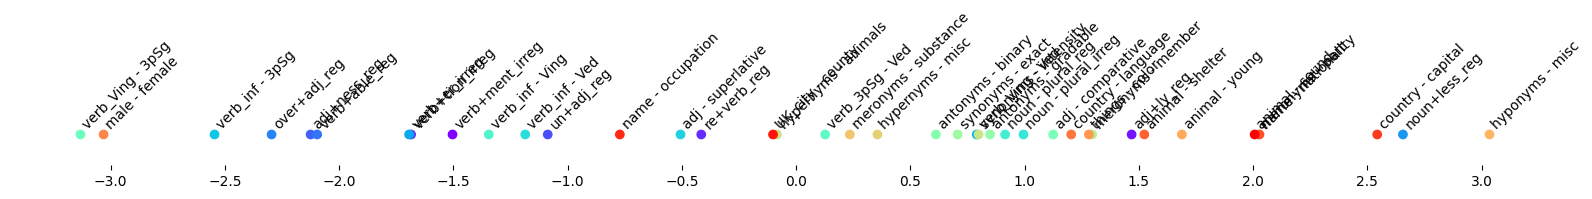

In [14]:
fig, ax = plt.subplots(figsize=(20, 2))

plt.scatter(angles, np.zeros_like(angles), c=np.linspace(0, 1, 40), cmap=plt.cm.rainbow)
plt.yticks([])
plt.ylim((-0.5, 2))
plt.xticks(np.linspace(-3, 3, 13))
plt.box(False)

text = [plt.text(a, 0.1, names[i], rotation=45) for i, a in enumerate(angles)]

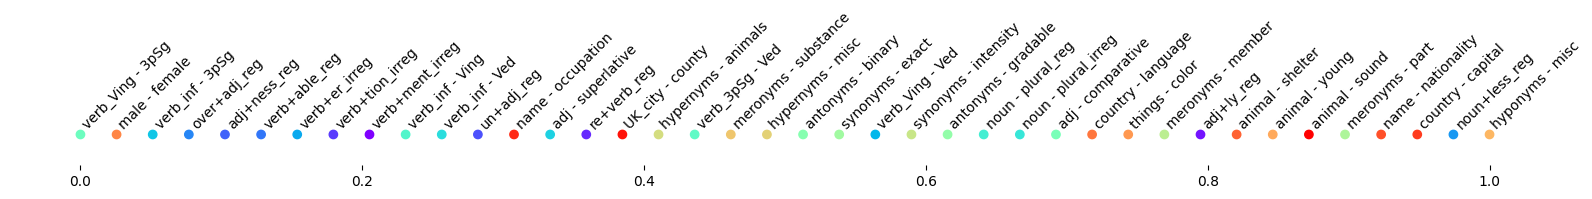

In [ ]:
fig, ax = plt.subplots(figsize=(20, 2))

order = np.argsort(angles)
even_points = np.linspace(0, 1, len(order))

plt.scatter(even_points, np.zeros_like(even_points), c=order, cmap=plt.cm.rainbow)
plt.yticks([])
plt.ylim((-0.5, 2))
plt.box(False)

text = [plt.text(x, 0.1, names[i], rotation=45) for i, x in zip(order, even_points)]